# DTWKmeans inertia demo

### Demo notebook for pynuTS 

Demonstrate the concept of inertia in K-Means clustering:

- Show how K-Means can fall into local minima
- Show the meaning of num_init parameter to run K-Means with more initialization options


For a defeinition of *inertia* : https://scikit-learn.org/stable/modules/clustering.html#k-means

In [1]:
# automatically reaload libraries (useful when working on libraries while playing with the notebook)
%load_ext autoreload
%autoreload 2

In [2]:
# allow import from parent directory
import sys,os
sys.path.append(os.getcwd() + '/..')

In [3]:
import pandas as pd
import numpy as np
import random
from pynuTS.clustering import DTWKmeans
import matplotlib.pyplot as plt

In [4]:
# import helper functions for dataset generation
from ts_gen import make_binary_code_dataset,make_flat_dataset,make_slopes_dataset
# import helper functions for dataset visualization
from ts_viz import plot_list_of_ts,plot_list_of_ts_over_subplots
# import helper functions to adjust list of series according to output of the clustering
from ts_utils import get_clustered_list

### Helper functions to extend pynuTS API
the functions below are candidate to be integrated into pynuTS 

In [5]:
help(get_clustered_list)

Help on function get_clustered_list in module ts_utils:

get_clustered_list(list_of_series, clusters_dict)
    Return a list of pandas series with series names adjusted according to the given clusters dictionary
    
    Arguments:
    
    list_of_series : list of Pandas Series. the name of the series is irrelevent
    
    clusters_dict : dictiorary associating clusters and series indexes in the input list
        example:  {0: [6, 7, 8], 1: [0, 1, 2], 2: [3, 4, 5]}
        means: cluster 0 is composed by series 6,7,8
               cluster 1 is composed by series 0,1,2
               cluster 2 is composed by series 3,4,5
    
    Returns:  copy of the list of series with names matching the clusters_dict



## Test dataset building functions: Flat noisy series
Synthetic time series with constant average and additive noise


In [6]:
help(make_flat_dataset)

Help on function make_flat_dataset in module ts_gen:

make_flat_dataset(levels, samples, level_noise_factor=0.01, additive_noise_factor=0.01, lengths=None, random_seed=None)
    Generate a list of flat time series of various levels with some white noise on the samples
    Lenght of each time series is 100 by default, can be changed with the lengths parameter.
    
    Arguments:
    -----------------------
    slopes : list of levels, e.g. [2.0,1.0,-1.0] means lines mean values will be 2.0, 1.0, -1.0
    
    samples : int or list of int, number of series produced for each slope
        if int, all clusters have the same size
        if list of int, size of each cluster. Shall have same length as slopes
    
    level_noise_factor : multiplier to a random factor added to the luevel
    
    additive_noise_factor : white noise multiplier added to each series
    
    lenghts : None or list of integers. If none all series will be of lenght 100. Otherwise lengths will be taken 
        at

# Build the dataset

Build a simple dataset with unbalanced (i.e. clusters have different number of members), flattish time series 

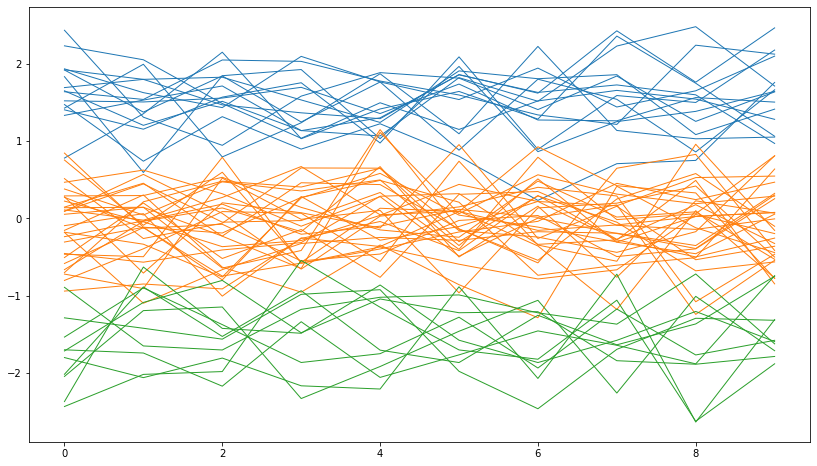

In [7]:
# build the dataset around 3 levels
levels = [1.5,0,-1.5]
# with different number of elements for each cluster
sizes = [15,30,10]
# set random seed for reproduceability, you can remove the argument to allow different results for each run
list_of_series = make_flat_dataset(levels,sizes,  
                                   additive_noise_factor=0.4,level_noise_factor=0.4,
                                   lengths=[10],random_seed=101)
plot_list_of_ts(list_of_series,figsize=(14,8))
plt.show()

#### pynuTS clusterization

In [8]:
# setting random seeds for each run for reproduceability
random_seeds_list = [22, 56, 36, 7, 66, -37, 58, 22, 80, 0]


Train 10  **DTWKmeans** classifiers with single initialization run each

In [9]:
runs = 10
intertia_list = []
classifiers_list = []

# remove the random_seed argument to allow random results at each run
for i in range(runs):
    clts = DTWKmeans(num_clust = 3, num_iter = 10, num_init=1, w=1,euclidean=True,random_seed=random_seeds_list[i])
    clts.fit(list_of_series)
    new_inertia=clts._inertia(list_of_series)
    intertia_list.append(new_inertia)
    classifiers_list.append(clts)
#print(intertia_list)



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00, 15.19it/s]


Plot intertia per each run - Not always all runs converge to minimum intertia

Text(0, 0.5, 'Inertia')

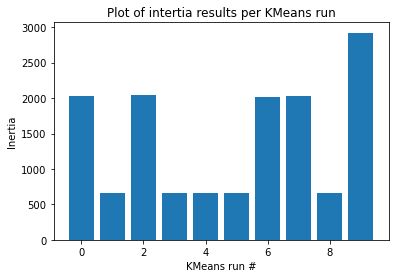

In [10]:
plt.bar(range(runs),intertia_list)
plt.title('Plot of intertia results per KMeans run')
plt.xlabel('KMeans run #')
plt.ylabel('Inertia')

In [11]:
best_case = intertia_list.index( min(intertia_list) )
worst_case = intertia_list.index( max(intertia_list) )

print(f'Best run is #{best_case} with inertia={intertia_list[best_case]}')
print(f'Worst run is #{worst_case} with inertia={intertia_list[worst_case]}')


Best run is #1 with inertia=664.4062428684266
Worst run is #9 with inertia=2922.5058992500763


We will now explore the best base and the worst case model on the basis of the inertia

##  Explore  worst case clustering result : algo fallen into local minima

In [12]:
clts = classifiers_list[worst_case]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


{0: [46, 50, 52, 54], 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], 2: [45, 47, 48, 49, 51, 53]}


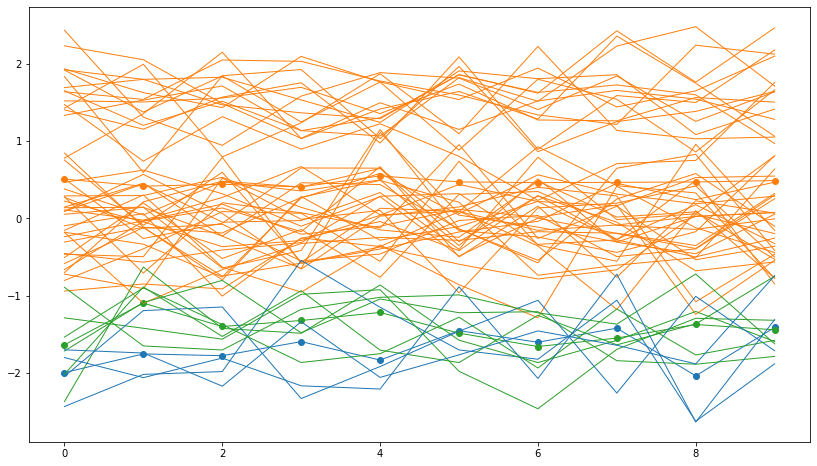

In [13]:
clustering_dict = clts.predict(list_of_series)
print(clustering_dict)
centroids_list = [pd.Series(c, name=i) for i,c in enumerate(clts.cluster_centers_)]
fig = plot_list_of_ts(centroids_list,figsize=(14,8),linewidth=4,marker='o')
plot_list_of_ts(get_clustered_list(list_of_series,clustering_dict),figure=fig)
plt.show()

##  Explore  best case clustering result

In [14]:
clts = classifiers_list[best_case]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


{0: [45, 46, 47, 48, 49, 50, 51, 52, 53, 54], 1: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]}


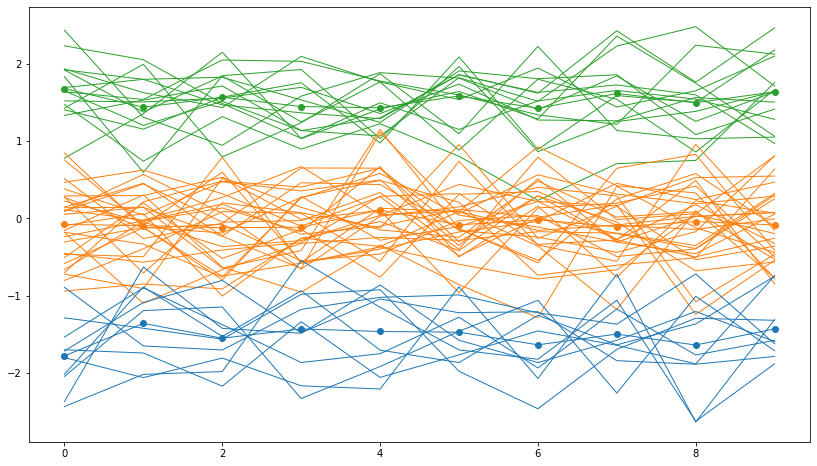

In [15]:
clustering_dict = clts.predict(list_of_series)
print(clustering_dict)
centroids_list = [pd.Series(c, name=i) for i,c in enumerate(clts.cluster_centers_)]
fig = plot_list_of_ts(centroids_list,figsize=(14,8),linewidth=4,marker='o')
plot_list_of_ts(get_clustered_list(list_of_series,clustering_dict),figure=fig)
plt.show()

# Run K-Means with multiple initializations

num_init is 1 by defualt. Running clustering with multiple initialization runs and selecting the best output on the basis of the inertia, helps escaping from local minima

In [16]:
# remove the random_seed argument to allow random results at each run
num_init = 1
random_seed = 0

clts = DTWKmeans(num_clust = 3, num_iter = 10, num_init=num_init, w=1,euclidean=True,random_seed=random_seed)
clts.fit(list_of_series)

inertia=clts._inertia(list_of_series)

print(f'Running {num_init} intializations runs, intertia = {inertia}')


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:00<00:00,  9.26it/s]

Running 1 intializations runs, intertia = 2922.5058992500763


In this simple example running 2 times is enough to demonstrate the case

In [17]:
# remove the random_seed argument to allow random results at each run
num_init = 2
random_seed = 0

clts = DTWKmeans(num_clust = 3, num_iter = 10, num_init=num_init, w=1,euclidean=True,random_seed=random_seed)
clts.fit(list_of_series)

inertia=clts._inertia(list_of_series)

print(f'Running {num_init} intializations runs, intertia = {inertia}')


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:00<00:00,  9.20it/s]

Running 2 intializations runs, intertia = 664.4062428684265


100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


{0: [45, 46, 47, 48, 49, 50, 51, 52, 53, 54], 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 2: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]}


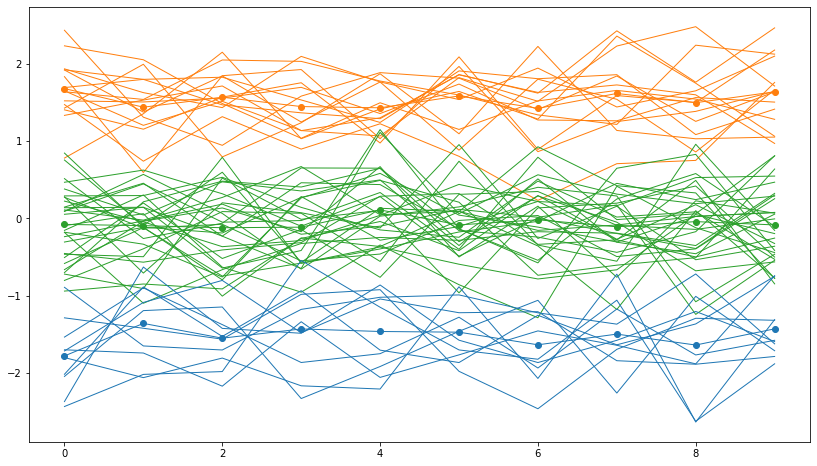

In [18]:
clustering_dict = clts.predict(list_of_series)
print(clustering_dict)
centroids_list = [pd.Series(c, name=i) for i,c in enumerate(clts.cluster_centers_)]
fig = plot_list_of_ts(centroids_list,figsize=(14,8),linewidth=4,marker='o')
plot_list_of_ts(get_clustered_list(list_of_series,clustering_dict),figure=fig)
plt.show()

### Credits

pynuTS by Nicola Procopio 2020

Original repository https://github.com/nickprock/pynuTS/

Demo notebook by Marcello Morchio 2020

Forked repository https://github.com/mallibus/pynuTS